## MVP Know Your Transaction (KYT) - Real-Time Transaction Risk Scoring Engine

### Project Overview

This notebook presents a comprehensive implementation of a Real-Time Transaction Risk Scoring Engine for Anti-Money Laundering (AML) compliance in cryptocurrency transactions. The project addresses the critical need for sub-second risk assessment of Bitcoin transactions by combining traditional AML indicators with blockchain-specific risk factors.

### Domain Context: Financial AML for Transactions

#### Core Domain Definition
Anti-Money Laundering (AML) for transactions encompasses the comprehensive framework of laws, regulations, procedures, and technological solutions designed to prevent criminals from disguising illegally obtained funds as legitimate income through the global financial system. This domain includes detection, prevention, and reporting of money laundering, terrorist financing, tax evasion, market manipulation, and misuse of public funds.

### Problem Definition: Real-Time Transaction Risk Classification Engine

#### Problem Statement
Develop a system that assigns risk classifications to cryptocurrency transactions in real-time, integrating traditional AML indicators with blockchain-specific risk factors including wallet clustering, transaction graph analysis, and counterparty reputation scoring.

#### Technical Requirements
- **Problem Type**: Classification 
- **Processing Speed**: Sub-second analysis for high-frequency transactions
- **Difficulty Level**: High - requires complex multi-dimensional data processing
- **Output Format**: Risk binary classification (illicit/licit)

#### Data Landscape
The system processes multiple data dimensions:
- Transaction metadata (amounts, timestamps, fees)
- Wallet addresses and clustering information
- Transaction graph relationships and network topology
- Counterparty databases and reputation scores
- Sanctions lists and regulatory databases
- Temporal patterns and behavioral baselines

### References

This notebook implementation is based on the comprehensive research and analysis conducted during the project development phase. The following reference documents were used in the composition of this initial description:

- **Domain Research**: [current-domain.md](domains/current-domain.md) - Contains detailed market analysis, regulatory framework research, and commercial viability assessment for the Financial AML domain
- **Problem Analysis**: [current-problem.md](problems/current-problem.md) - Provides comprehensive problem refinement, technical requirements analysis, and solution approach evaluation
- **Dataset Evaluation**: [current-dataset.md](datasets/current-dataset.md) - Documents dataset selection criteria, suitability scoring, and detailed feature analysis for the Elliptic dataset
- **Dataset Analysis & Preprocessing**: [dataset-analysis-and-preprocessing.ipynb](datasets/scripts/dataset-analysis-and-preprocessing.ipynb) - Comprehensive Jupyter notebook containing Elliptic dataset download, exploratory data analysis, feature engineering, preprocessing pipeline, and ML preparation steps

These reference documents contain the foundational research that informed the technical approach, feature engineering strategy, and implementation decisions reflected in this notebook.

---

This notebook serves as the primary entry point for the MVP KYT implementation, providing both technical implementation and business context for real-time cryptocurrency transaction risk assessment.

### Import Libraries

Comprehensive import of all required libraries for machine learning procedures.

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

### Loading pre-processed datasets

The pre-processing step reduced the dimensionality from 166 features to only 46.

In [2]:

# The complete dataset already pre-processed 
df_complete = pd.read_hdf("./datasets/processed/df_complete.h5", key="df_complete")
print(f"Loaded from HDF5: {df_complete.shape} - All subsequent operations will use compressed data")

# The filtered labeled dataset already pre-processed
df_labeled = pd.read_hdf("./datasets/processed/df_labeled.h5", key="df_labeled")
print(f"Loaded from HDF5: {df_labeled.shape} - All subsequent operations will use compressed data")

# The filtered unlabeled dataset already pre-processed
df_unlabeled = pd.read_hdf("./datasets/processed/df_unlabeled.h5", key="df_unlabeled")
print(f"Loaded from HDF5: {df_unlabeled.shape} - All subsequent operations will use compressed data")

# The edges dataset that maps relationships between transaction nodes
df_edges = pd.read_hdf("./datasets/processed/df_edges.h5", key="df_edges")
print(f"Loaded from HDF5: {df_edges.shape} - All subsequent operations will use compressed data")


# Summary of all datasets
print(f"\n📊 Dataset Summary:")
print(f"  - Features: {df_complete.shape[0]:,} transactions × {df_complete.shape[1] -2} features")
print(f"  - Labeled: {df_labeled.shape[0]:,} transactions")
print(f"  - Unlabeled: {df_unlabeled.shape[0]:,} transactions")
print(f"  - Edges: {df_edges.shape[0]:,} transaction relationships")

Loaded from HDF5: (203769, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (46564, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (157205, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (234355, 2) - All subsequent operations will use compressed data

📊 Dataset Summary:
  - Features: 203,769 transactions × 166 features
  - Labeled: 46,564 transactions
  - Unlabeled: 157,205 transactions
  - Edges: 234,355 transaction relationships


### Machine Learning Strategy

Let's apply the machine learning technics:

1. Define overall parameters and make data splits
2. Defining all training models to be used
3. Defining all pipelines to be used during training
4. Defining model parameters distribution for a grid search approach
5. Execute the training
6. Save all resulting models
7. Validate all models and select the best models
8. Use best models to predict unknown data 


**1.Define overall parameters and make data splits**

Let`s prepare the dataset for training and validation

[Description]
[Whys]
[What]
[When]

In [ ]:
# Defining overall parameters
random_seed = 4354 # PARAMETER: random seed
test_size_split = 0.20 # PARAMETER: test set size
n_stratified_splits = 2 # PARAMETER: number of folds
n_pca_components = 0.95 # PARAMETER: PCA components to keep

np.random.seed(random_seed)

# Prepare data (df_labeled already loaded: 46,564 × 48)
x_labeled = df_labeled.drop(['class', 'txId'], axis=1)  # 46 features
y_labeled = df_labeled['class']  # Binary target

X_train, X_test, y_train, y_test = train_test_split(x_labeled, y_labeled,
    test_size=test_size_split, 
    shuffle=True, 
    random_state=random_seed, 
    stratify=y_labeled) # stratified holdout

# Cross-validation setup
cv = StratifiedKFold(n_splits=n_stratified_splits, 
                     shuffle=True, 
                     random_state=random_seed)

**2. Defining all training models to be used**

Let's define which models to use

[Description]
[Whys]
[What]
[When]

In [67]:
# Defining the individual models
reg = ('LR', LogisticRegression())
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive = ('NB', GaussianNB())
svm = ('SVM', SVC())

models = []
models.append(reg)
models.append(knn)
models.append(cart)
models.append(naive)
models.append(svm)

# Defining ensemble models
bagging = ('Bag', BaggingClassifier())
forest = ('RF', RandomForestClassifier())
extra = ('ET', ExtraTreesClassifier())
ada = ('Ada', AdaBoostClassifier())
gradient = ('GB', GradientBoostingClassifier())
voting = ('Voting', VotingClassifier(models))

**3. Defining all pipelines to be used during training**

Let's define which ML pipelines to use during training.

[Description]
[Whys]
[What]
[When]

This section focuses on selecting the most relevant features for distinguishing between licit (class 1) and illicit (class 2) transactions. We are aiming to reduce the feature dimensionality at the same time as maximizing the dissimilarity of the original dataset, thus extracting the most discriminative features and improving the model training performance. Let`s apply the following technics:

In [68]:
# Creating the pipelines
pipelines = []
std  = ('std', StandardScaler())  # Standardization
pca = ('pca', PCA(n_components=n_pca_components))  # Feature reduction

# Defining the pipelines, for future experimentation 
pipelines.append(('LR', Pipeline([std, pca, reg]))) 
pipelines.append(('KNN', Pipeline([std, pca, knn])))
pipelines.append(('CART', Pipeline([std, pca, cart])))
pipelines.append(('NB', Pipeline([std, pca, naive])))
pipelines.append(('SVM', Pipeline([std, pca, svm])))
pipelines.append(('Bag', Pipeline([std, pca, bagging])))
pipelines.append(('RF', Pipeline([std, pca, forest])))
pipelines.append(('ET', Pipeline([std, pca, extra])))
pipelines.append(('Ada', Pipeline([std, pca, ada])))
pipelines.append(('GB', Pipeline([std, pca, gradient])))
#pipelines.append(('Vot', Pipeline([std, pca, voting])))

**4. Defining model parameters distribution for a grid search approach**

Let's prepare the parameter distributions for a random grid search

[Description]
[Whys]
[What]
[When]

In [69]:
# Define parameter distributions for RandomizedSearchCV
# Enhanced with log-uniform distributions and comprehensive documentation
# Optimized for financial/cryptocurrency transaction risk classification

param_distributions = {
    'LR': {
        # REGULARIZATION STRENGTH (C): Inverse regularization strength
        # Lower values = stronger regularization = simpler model (prevent overfitting)
        # Higher values = weaker regularization = more complex model
        # Log-uniform for exponential search across orders of magnitude
        # Critical for financial data: balance between model complexity and generalization
        'LR__C': loguniform(1e-4, 1e2),

        # OPTIMIZATION SOLVER: Algorithm for weight optimization
        # 'lbfgs': Fast for small datasets, good convergence, handles L2/none penalty
        # 'newton-cg': Robust for large datasets, handles L2/none penalty
        # 'sag': Stochastic Average Gradient, fast for large datasets
        # 'saga': Supports all penalties, good for sparse features (financial data)
        # Removed 'liblinear': slower for datasets > 10K samples
        'LR__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],

        # REGULARIZATION TYPE: Controls feature selection and overfitting
        # 'l2': Ridge regression, keeps all features, reduces coefficients
        # 'none': No regularization, may overfit with many features
        # Removed 'l1': Lasso causes issues with solver compatibility
        # Financial context: L2 better for correlated transaction features
        'LR__penalty': ['l2', 'none'],

        # MAXIMUM ITERATIONS: Convergence limit for optimization
        # Higher values ensure convergence but increase training time
        # Financial data often needs more iterations due to class imbalance
        # 2000+ recommended for 46K+ samples to avoid convergence warnings
        'LR__max_iter': [1000, 2000, 5000],

        # CONVERGENCE TOLERANCE: Stopping criteria precision
        # Lower values = more precise convergence = longer training time
        # Financial models need precise convergence for regulatory compliance
        # 1e-6: High precision, 1e-4: Fast convergence
        'LR__tol': loguniform(1e-6, 1e-3)
    },

    'KNN': {
        # NUMBER OF NEIGHBORS: Core hyperparameter for KNN algorithm
        # Lower values = more complex decision boundary = higher variance
        # Higher values = smoother decision boundary = higher bias
        # Financial context: 5-15 often optimal for transaction classification
        # Odd numbers prevent ties in binary classification
        'KNN__n_neighbors': randint(3, 21),

        # WEIGHT FUNCTION: How neighbors influence prediction
        # 'uniform': All neighbors weighted equally
        # 'distance': Closer neighbors have higher influence
        # Financial context: 'distance' often better for transaction patterns
        'KNN__weights': ['uniform', 'distance'],

        # DISTANCE METRIC: How to measure similarity between transactions
        # 'euclidean': Standard L2 distance, good for continuous features
        # 'manhattan': L1 distance, robust to outliers (good for financial data)
        # 'minkowski': Generalization, controlled by 'p' parameter
        'KNN__metric': ['euclidean', 'manhattan', 'minkowski'],

        # MINKOWSKI POWER: Only used when metric='minkowski'
        # p=1: Manhattan distance, p=2: Euclidean distance
        # Financial data: p=1 often better due to outlier robustness
        'KNN__p': randint(1, 3)
    },

    'CART': {
        # MAXIMUM TREE DEPTH: Primary overfitting control
        # Lower values = simpler tree = less overfitting = higher bias
        # Financial context: 5-15 often optimal for interpretability vs performance
        # Too deep trees memorize transactions instead of learning patterns
        'CART__max_depth': randint(3, 20),

        # MINIMUM SAMPLES TO SPLIT: Prevents splitting on small sample sizes
        # Higher values = more conservative splits = less overfitting
        # Financial context: 10-50 good for 46K+ dataset to ensure robust splits
        'CART__min_samples_split': randint(10, 50),

        # MINIMUM SAMPLES PER LEAF: Ensures leaf nodes have sufficient samples
        # Higher values = smoother predictions = less overfitting
        # Critical for financial data: prevents decisions based on few transactions
        'CART__min_samples_leaf': randint(5, 20),

        # SPLIT QUALITY MEASURE: Criterion for evaluating split quality
        # 'gini': Gini impurity, faster computation
        # 'entropy': Information gain, potentially better separation
        # Financial context: both work well, entropy slightly better for imbalanced data
        'CART__criterion': ['gini', 'entropy']
    },

    'NB': {
        # VARIANCE SMOOTHING: Laplace smoothing for numerical stability
        # Prevents zero probabilities when features have zero variance
        # Log-uniform for exponential search across precision levels
        # Financial context: 1e-9 to 1e-6 range good for PCA-transformed features
        'NB__var_smoothing': loguniform(1e-12, 1e-6),

        # CLASS PRIORS: Prior probabilities for each class
        # None: Learn priors from training data (recommended)
        # Custom priors could be set based on known illicit transaction rates
        'NB__priors': [None]
    },

    'SVM': {
        # REGULARIZATION PARAMETER: Trade-off between margin and misclassification
        # Lower C = wider margin = more regularization = simpler model
        # Higher C = narrower margin = less regularization = complex model
        # Log-uniform critical for SVM: performance varies across orders of magnitude
        # Financial context: Often needs tuning from 0.01 to 1000
        'SVM__C': loguniform(1e-2, 1e3),

        # KERNEL FUNCTION: Maps features to higher-dimensional space
        # 'rbf': Radial basis function, good for non-linear financial patterns
        # 'poly': Polynomial kernel, can capture feature interactions
        # 'sigmoid': Tanh kernel, neural network-like behavior
        # Removed 'linear': redundant with LogisticRegression for PCA features
        'SVM__kernel': ['rbf', 'poly', 'sigmoid'],

        # KERNEL COEFFICIENT: Controls kernel shape and influence
        # 'scale': 1/(n_features * X.var()) - good default for normalized data
        # 'auto': 1/n_features - simpler scaling
        # Log-uniform range would be loguniform(1e-6, 1e-1) for custom values
        'SVM__gamma': ['scale', 'auto']
    },

    'RF': {
        # NUMBER OF TREES: Primary performance vs speed trade-off
        # More trees = better performance = longer training/prediction time
        # Financial context: 100-500 often optimal, diminishing returns after 300
        # Real-time KYT systems need to balance accuracy with inference speed
        'RF__n_estimators': randint(100, 500),

        # MAXIMUM TREE DEPTH: Individual tree complexity control
        # None = trees grow until pure leaves (may overfit)
        # Specific values prevent overfitting in ensemble
        # Financial context: 10-25 good for transaction complexity
        'RF__max_depth': randint(10, 25),

        # MINIMUM SAMPLES TO SPLIT: Conservative splitting threshold
        # Higher values = more robust trees = better generalization
        # Financial data: 5-20 good for 46K+ samples
        'RF__min_samples_split': randint(5, 20),

        # MINIMUM SAMPLES PER LEAF: Leaf node size constraint
        # Prevents overfitting to individual transactions
        # Financial context: 2-10 ensures meaningful leaf nodes
        'RF__min_samples_leaf': randint(2, 10),

        # FEATURE SUBSET SIZE: Number of features per tree split
        # 'sqrt': sqrt(n_features) ≈ 7 features for 46 total
        # 'log2': log2(n_features) ≈ 6 features for 46 total
        # None: Use all features (may reduce diversity)
        # Financial context: 'sqrt' often optimal for transaction features
        'RF__max_features': ['sqrt', 'log2', None],

        # BOOTSTRAP SAMPLING: Sample replacement for tree training
        # True: Standard random forest with replacement sampling
        # False: Use entire dataset for each tree (less diversity)
        # Financial context: True recommended for better generalization
        'RF__bootstrap': [True, False]
    },

    'ET': {
        # Extra Trees: Similar to Random Forest but with random splits
        # Generally faster training, sometimes better performance
        # Parameters similar to Random Forest but more aggressive randomization

        'ET__n_estimators': randint(100, 500),          # Number of trees in ensemble
        'ET__max_depth': randint(10, 25),               # Maximum depth of trees
        'ET__min_samples_split': randint(5, 20),        # Min samples to split node
        'ET__min_samples_leaf': randint(2, 10),         # Min samples at leaf
        'ET__max_features': ['sqrt', 'log2', None],     # Random feature subset size
        'ET__bootstrap': [True, False]                  # Bootstrap sampling toggle
    },

    'GB': {
        # BOOSTING STAGES: Number of sequential weak learners
        # More stages = better performance = higher overfitting risk
        # Financial context: 100-300 often optimal, early stopping recommended
        'GB__n_estimators': randint(100, 300),

        # LEARNING RATE: Step size shrinkage for gradient updates
        # Lower rates = more conservative learning = need more estimators
        # Higher rates = aggressive learning = risk of overshooting optimum
        # Log-uniform for exponential search: 0.01-0.3 typical range
        # Financial context: 0.05-0.15 often optimal for stability
        'GB__learning_rate': loguniform(1e-2, 3e-1),

        # INDIVIDUAL TREE DEPTH: Weak learner complexity
        # Gradient boosting uses shallow trees (stumps to 8 levels)
        # Higher depth = stronger individual learners = risk of overfitting
        # Financial context: 3-8 optimal for transaction patterns
        'GB__max_depth': randint(3, 8),

        # SUBSAMPLE FRACTION: Stochastic gradient boosting
        # < 1.0 = use random subset of samples for each tree
        # Reduces overfitting and improves generalization
        # Financial context: 0.7-0.9 good for large transaction datasets
        'GB__subsample': uniform(0.7, 0.2)  # 0.7 to 0.9 range
    },

    'Ada': {
        # ADAPTIVE BOOSTING: Sequential weak learner weighting
        # Focuses on previously misclassified transactions

        # NUMBER OF WEAK LEARNERS: Maximum boosting rounds
        # AdaBoost often needs fewer estimators than Gradient Boosting
        # Financial context: 50-200 sufficient for most transaction patterns
        'Ada__n_estimators': randint(50, 200),

        # LEARNING RATE: Weight applied to each weak classifier
        # Lower rates = more conservative = better generalization
        # Higher rates = aggressive = faster convergence but overfitting risk
        # Financial context: 0.5-1.5 range for transaction classification
        'Ada__learning_rate': uniform(0.5, 1.0),  # 0.5 to 1.5 range

        # BOOSTING ALGORITHM: AdaBoost variant
        # 'SAMME': Discrete AdaBoost, works with any base classifier
        # 'SAMME.R': Real AdaBoost, requires probability estimates
        # Financial context: SAMME.R often faster and more accurate
        'Ada__algorithm': ['SAMME', 'SAMME.R']
    },

    'Bag': {
        # BOOTSTRAP AGGREGATING: Parallel ensemble method
        # Reduces overfitting through averaging multiple models

        'Bag__n_estimators': randint(50, 200),          # Number of base estimators

        # SAMPLE FRACTION: Proportion of dataset for each estimator
        # Lower values = more diversity = better generalization
        # Higher values = more stable individual models
        # Financial context: 0.6-0.9 good for transaction data diversity
        'Bag__max_samples': uniform(0.6, 0.3),  # 0.6 to 0.9 range

        # FEATURE FRACTION: Proportion of features for each estimator
        # Creates feature diversity in ensemble
        # Financial context: 0.7-1.0 to maintain transaction pattern integrity
        'Bag__max_features': uniform(0.7, 0.3)   # 0.7 to 1.0 range
    }
}

**5. Execute the training**

Let's execute the training phase using the random grid search with cross validation and rank the best models by accuracy.

[Description]
[Whys]
[What]
[When]

In [ ]:
# Training parameters
gs_iter = 5  # PARAMETER: Number of parameter combinations to try
gs_scoring = 'accuracy' # PARAMETER: Scoring metric
gs_jobs = -1  # PARAMETER: Use all available cores
gs_verbosity = 1  # PARAMETER: Verbosity level

# Create result collections
optimized_models = []
results = []

print("🔍 Training Models with RandomizedSearchCV Optimization...")
print(f"Training {len(pipelines)} models: Basic + Ensemble methods")
print("-" * 60)

for name, pipe in pipelines:
    print(f"Training {name}...", end=" ")
    random_search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_distributions[name],
            n_iter=gs_iter,
            cv=cv,
            verbose=gs_verbosity,
            scoring=gs_scoring,
            random_state=random_seed,
            n_jobs=gs_jobs
    )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_score = random_search.best_score_
    std_score = random_search.cv_results_['std_test_score'][random_search.best_index_]
        
    print(f"✅ {best_score:.4f} (±{std_score:.4f})")
    
    optimized_models.append((name, best_model))
    results.append(best_score)

fig = plt.figure(figsize=(25,6))
fig.suptitle('Trained Models Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels([x[0] for x in optimized_models])
plt.show()

🔍 Training Models with RandomizedSearchCV Optimization...
Training 10 models: Basic + Ensemble methods
------------------------------------------------------------
Training LR... 

/home/raphael-pizzaia/miniconda/envs/venv-analytics/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
8 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/raphael-pizzaia/miniconda/envs/venv-analytics/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/raphael-pizzaia/miniconda/envs/venv-analytics/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File 

✅ 0.9055 (±0.0002)
Training KNN... ✅ 0.9687 (±0.0003)
Training CART... ✅ 0.9608 (±0.0012)
Training NB... ✅ 0.6869 (±0.0103)
Training SVM... ✅ 0.9778 (±0.0012)
Training Bag... ✅ 0.9719 (±0.0014)
Training RF... ✅ 0.9712 (±0.0015)
Training ET... ✅ 0.9697 (±0.0001)
Training Ada... 

/home/raphael-pizzaia/miniconda/envs/venv-analytics/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/raphael-pizzaia/miniconda/envs/venv-analytics/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/raphael-pizzaia/miniconda/envs/venv-analytics/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
8 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits 

✅ 0.9580 (±0.0006)
Training GB... ✅ 0.9746 (±0.0002)


**6. Save all resulting models**

Let's save all models

[Description]
[Whys]
[What]
[When]

In [4]:
try:
    # Try to save models from training
    folderDir = "./models/mvp-kyt-sup-main"
    os.makedirs(folderDir, exist_ok=True)
    for name, pipe in optimized_models:
        joblib.dump(pipe, f"{folderDir}/{name}.pkl", compress=True)
    print(f"💾 Saved {len(optimized_models)} models: {[name for name, _ in optimized_models]}")
except NameError:
    # Load models if optimized_models doesn't exist
    optimized_models = []
    if os.path.exists(folderDir):
        for file in os.listdir(folderDir):
            if file.endswith('.pkl'):
                name = file.replace('.pkl', '')
                pipe = joblib.load(f"{folderDir}/{file}")
                optimized_models.append((name, pipe))
        print(f"📁 Loaded {len(optimized_models)} models: {[name for name, _ in optimized_models]}")
    else:
        print("❌ No models found")

📁 Loaded 10 models: ['NB', 'CART', 'Bag', 'GB', 'LR', 'KNN', 'Ada', 'ET', 'RF', 'SVM']


**7. Validate all models and select the best models**

Let's validate and select the best models

[Description]
[Whys]
[What]
[When]

NB: Test Accuracy = 0.6866
CART: Test Accuracy = 0.9589
Bag: Test Accuracy = 0.9727
GB: Test Accuracy = 0.9741
LR: Test Accuracy = 0.9088
KNN: Test Accuracy = 0.9726
Ada: Test Accuracy = 0.9552
ET: Test Accuracy = 0.9708
RF: Test Accuracy = 0.9703
SVM: Test Accuracy = 0.9790


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (10).

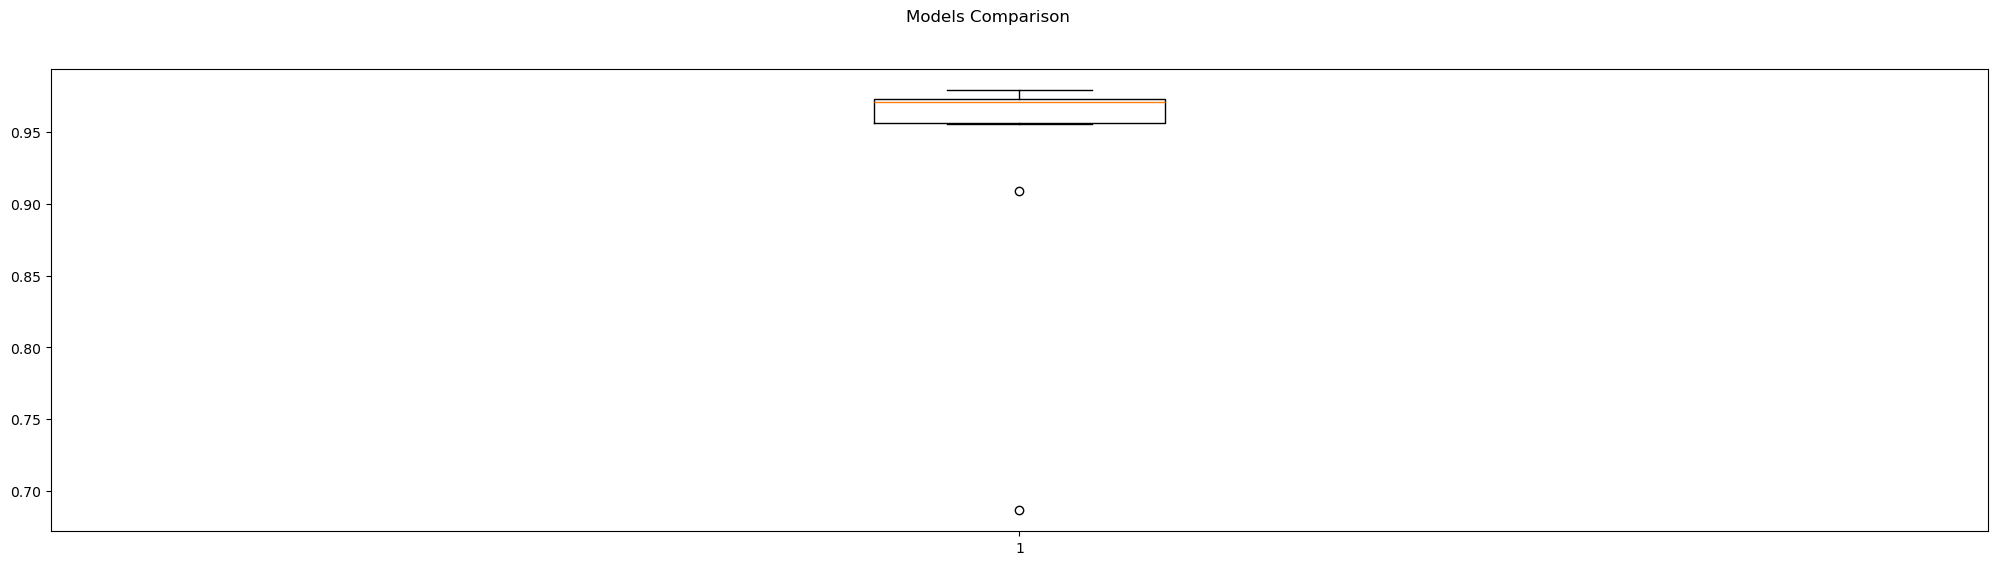

In [23]:
# Select best 3 models based on test accuracy
test_results = []
for name, pipe in optimized_models:
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    test_results.append((name, accuracy))
    print(f"{name}: Test Accuracy = {accuracy:.4f}")

# Comparison Boxplot
fig = plt.figure(figsize=(25,6))
fig.suptitle('Models Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot([x[1] for x in test_results]) 
ax.set_xticklabels([x[0] for x in test_results])
plt.show()

# Sort by test accuracy and get top 3
test_results.sort(key=lambda x: x[2], reverse=True)
best_optimized_models = [(name, model) for name, model, acc in test_results[:3]]

print(f"\n🏆 Final top 3 models: {[name for name, _ in best_optimized_models]}")
print(f"📊 Test accuracies: {[f'{acc:.4f}' for _, _, acc in test_results[:3]]}")


**8. Use best models to predict unknown data**

Let`s apply the model into unknown data

[Description]
[Whys]
[What]
[When]

In [9]:
# Apply best model to unlabeled data
best_model = best_optimized_models[0][1]  # Champion model
X_unlabeled = df_unlabeled.drop(['class', 'txId'], axis=1)

predictions = best_model.predict(X_unlabeled)
probabilities = best_model.predict_proba(X_unlabeled)[:, 1]
display(predictions)
print(f"🔮 Predictions on {len(X_unlabeled)} unlabeled transactions")
#print(f"Illicit predictions: {sum(predictions)} ({sum(predictions)/len(predictions)*101:.1f}%)")
print(f"Risk scores range: {probabilities.min():.3f} - {probabilities.max():.3f}")

AttributeError: This 'Pipeline' has no attribute 'predict_proba'

### Conclusions

[conclusion]